In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input, Dense, Lambda
from keras.models import Model
from keras import regularizers
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_recall_curve, classification_report, roc_curve, auc, accuracy_score, f1_score, precision_score, recall_score, auc, matthews_corrcoef, roc_curve, roc_auc_score
from tensorflow.python.framework.ops import disable_eager_execution

disable_eager_execution()

2023-05-29 01:54:15.867613: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# configure Keras to use GPU
tf.config.experimental.set_visible_devices([], 'GPU')

# Load the data
df = pd.read_csv("creditcard.csv")

std_scaler = StandardScaler()

df['scaled_amount'] = std_scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = std_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Amount'], inplace=True, axis = 1)
df.drop(['Time'], inplace=True, axis = 1)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop('Class', axis=1), df['Class'], test_size=0.2, random_state=42)

In [3]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
223361,1.955041,-0.380783,-0.315013,0.330155,-0.509374,-0.086197,-0.627978,0.035994,1.054560,-0.030441,...,0.238197,0.968305,0.053208,-0.278602,-0.044999,-0.216780,0.045168,-0.047145,-0.313289,1.022112
165061,-0.400975,-0.626943,1.555339,-2.017772,-0.107769,0.168310,0.017959,-0.401619,0.040378,0.611115,...,-0.153485,0.421703,0.113442,-1.004095,-1.176695,0.361924,-0.370469,-0.144792,-0.169717,0.470837
238186,0.072509,0.820566,-0.561351,-0.709897,1.080399,-0.359429,0.787858,0.117276,-0.131275,-0.638222,...,-0.314638,-0.872959,0.083391,0.148178,-0.431459,0.119690,0.206395,0.070288,-0.305292,1.152945
150562,-0.535045,1.014587,1.750679,2.769390,0.500089,1.002270,0.847902,-0.081323,0.371579,0.560595,...,0.063525,0.443431,-0.072754,0.448192,-0.655203,-0.181038,-0.093013,-0.064931,0.116306,-0.024087
138452,-4.026938,1.897371,-0.429786,-0.029571,-0.855751,-0.480406,-0.435632,1.313760,0.536044,1.221746,...,-0.480691,-0.230369,0.250717,0.066399,0.470787,0.245335,0.286904,-0.322672,-0.250239,-0.256040
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119879,1.173488,0.100792,0.490512,0.461596,-0.296377,-0.213165,-0.165254,0.119221,-0.114199,0.079128,...,-0.186027,-0.574283,0.161405,-0.006140,0.091444,0.109235,-0.020922,0.003967,-0.345313,-0.404225
259178,-0.775981,0.144023,-1.142399,-1.241113,1.940358,3.912076,-0.466107,1.360620,0.400697,-0.654029,...,0.037078,-0.019575,0.241830,0.682820,-1.635109,-0.770941,0.066006,0.137056,0.003520,1.351627
131932,-0.146609,0.992946,1.524591,0.485774,0.349308,-0.815198,1.076640,-0.395316,-0.491303,-0.212753,...,0.052649,0.354089,-0.291198,0.402849,0.237383,-0.398467,-0.121139,-0.196195,-0.337477,-0.316266
146867,-2.948638,2.354849,-2.521201,-3.798905,1.866302,2.727695,-0.471769,2.217537,0.580199,-0.027572,...,-0.332759,-1.047514,0.143326,0.678869,0.319710,0.426309,0.496912,0.335822,-0.349231,-0.144939


In [4]:
# Create an autoencoder to generate synthetic fraud data
input_dim = X_train.shape[1]
encoding_dim = int(input_dim / 2)

input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Train the autoencoder on normal transactions
X_normal = X_train[y_train == 0]
X_normal_train, X_normal_test = train_test_split(X_normal, test_size=0.2, random_state=42)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
history = autoencoder.fit(X_normal_train, X_normal_train, epochs=100, batch_size=32, validation_data=(X_normal_test, X_normal_test))

# Generate synthetic fraud transactions using the trained autoencoder
X_fraud = X_train[y_train == 1]
synthetic_fraud = autoencoder.predict(X_fraud)

#encoded_normal = autoencoder.predict(X)
noise_factor = 0.2
encoded_normal_noisy = synthetic_fraud + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=synthetic_fraud.shape)
synthetic_fraud_data = autoencoder.predict(encoded_normal_noisy)

# Combine the synthetic fraud transactions with the original fraud transactions
X_fraud = np.vstack((X_fraud, synthetic_fraud_data)) #synthetic_fraud

# Combine the normal transactions with the fraud transactions
X_balanced = np.vstack((X_normal, X_fraud))
y_balanced = np.hstack((np.zeros(X_normal.shape[0]), np.ones(X_fraud.shape[0])))

Train on 181960 samples, validate on 45491 samples
Epoch 1/100
  5504/181960 [..............................] - ETA: 7s - loss: 0.9944 

2023-05-29 01:54:20.062820: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/dense_3/kernel/v/Assign' id:338 op device:{requested: '', assigned: ''} def:{{{node training/Adam/dense_3/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/dense_3/kernel/v, training/Adam/dense_3/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


181376/181960 [============================>.] - ETA: 0s - loss: 0.8123

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-05-29 01:54:23.330866: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/AddN' id:129 op device:{requested: '', assigned: ''} def:{{{node loss/AddN}} = AddN[N=2, T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul, dense/ActivityRegularizer/truediv)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


181960/181960 [==============================] - 4s 20us/sample - loss: 0.8124 - val_loss: 0.7813
Epoch 2/100
181960/181960 [==============================] - 4s 20us/sample - loss: 0.7427 - val_loss: 0.7610
Epoch 3/100
181960/181960 [==============================] - 4s 20us/sample - loss: 0.7292 - val_loss: 0.7505
Epoch 4/100
181960/181960 [==============================] - 4s 20us/sample - loss: 0.7214 - val_loss: 0.7446
Epoch 5/100
181960/181960 [==============================] - 4s 20us/sample - loss: 0.7150 - val_loss: 0.7383
Epoch 6/100
181960/181960 [==============================] - 5s 25us/sample - loss: 0.7113 - val_loss: 0.7346
Epoch 7/100
181960/181960 [==============================] - 5s 25us/sample - loss: 0.7085 - val_loss: 0.7317
Epoch 8/100
181960/181960 [==============================] - 5s 27us/sample - loss: 0.7068 - val_loss: 0.7344
Epoch 9/100
181960/181960 [==============================] - 6s 30us/sample - loss: 0.7049 - val_loss: 0.7280
Epoch 10/100
181960/18

Epoch 75/100
181960/181960 [==============================] - 5s 30us/sample - loss: 0.6972 - val_loss: 0.7189
Epoch 76/100
181960/181960 [==============================] - 6s 30us/sample - loss: 0.6963 - val_loss: 0.7214
Epoch 77/100
181960/181960 [==============================] - 6s 31us/sample - loss: 0.6965 - val_loss: 0.7234
Epoch 78/100
181960/181960 [==============================] - 6s 31us/sample - loss: 0.6966 - val_loss: 0.7224
Epoch 79/100
181960/181960 [==============================] - 5s 30us/sample - loss: 0.6967 - val_loss: 0.7187
Epoch 80/100
181960/181960 [==============================] - 6s 31us/sample - loss: 0.6967 - val_loss: 0.7192
Epoch 81/100
181960/181960 [==============================] - 5s 30us/sample - loss: 0.6969 - val_loss: 0.7230
Epoch 82/100
181960/181960 [==============================] - 5s 30us/sample - loss: 0.6965 - val_loss: 0.7207
Epoch 83/100
181960/181960 [==============================] - 6s 31us/sample - loss: 0.6970 - val_loss: 0.7195
E

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-05-29 02:03:27.292134: W tensorflow/c/c_api.cc:300] Operation '{name:'dense_3/Relu' id:110 op device:{requested: '', assigned: ''} def:{{{node dense_3/Relu}} = Relu[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_3/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


In [5]:
# Apply SMOTE Oversampling to balance the dataset
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_balanced, y_balanced)

# Fit the random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_balanced, y_train_balanced)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Compute the accuracy and confusion matrix
accuracy = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print('Accuracy:', accuracy)
print('Confusion matrix:\n', cm)
##################################

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Accuracy: 0.9995962220427653
Confusion matrix:
 [[56858     6]
 [   17    81]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.93      0.83      0.88        98

    accuracy                           1.00     56962
   macro avg       0.97      0.91      0.94     56962
weighted avg       1.00      1.00      1.00     56962



/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


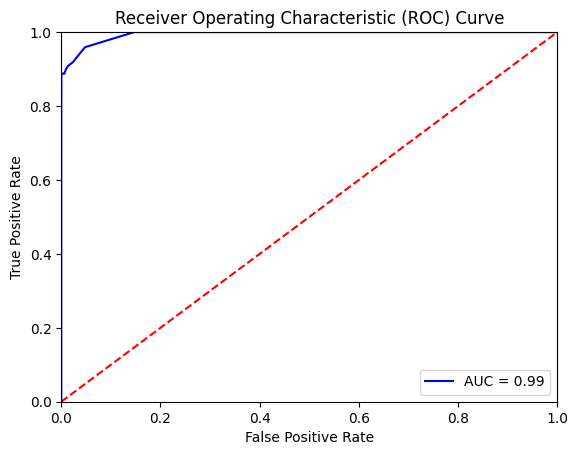

Accuracy: 0.999596
F1-score:  0.8756756756756757
Precision:  0.9310344827586207
Recall:  0.826530612244898
Specificity:  0.9998944850872257
Sensitivity:  0.826530612244898
AUC:  0.9941921038955819
Matthews correlation coefficient: 0.8770309251466589


In [6]:
print(classification_report(y_test, y_pred))

y_pred_proba = rf.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc = 'lower right')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
specificity = tn / (tn+fp)
sensitivity = recall
auc = roc_auc_score(y_test, y_pred_proba)

print("Accuracy: %f" % accuracy)
print("F1-score: ", f1)
print("Precision: ", precision)
print("Recall: ", recall)
print("Specificity: ", specificity)
print("Sensitivity: ", sensitivity)
print("AUC: ", auc)

mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews correlation coefficient:", mcc)

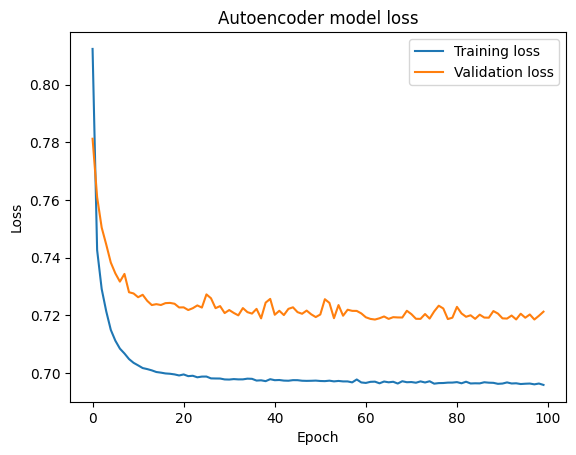

In [7]:
# plot the loss graph
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Autoencoder model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
X_test

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
43428,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,-14.110184,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1.102834,-1.122574
49906,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,-0.565012,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,1.726255,-1.064538
29474,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,0.756801,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,-0.229289,-1.249364
276481,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,-1.376648,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,-0.347232,1.522680
278846,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,0.259452,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,-0.349671,1.551109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75723,-1.994348,1.503076,-0.365560,0.780223,-0.957956,0.038648,-0.453702,1.553565,-0.561964,-0.100318,...,0.224820,0.319275,-0.081356,-0.366704,-0.269380,-0.278170,0.082042,-0.015071,-0.050614,-0.812643
252263,-0.234567,0.733694,0.486250,-0.718186,0.782227,-0.788837,1.056307,-0.175016,-0.244864,-0.708527,...,-0.202040,-0.574857,-0.024845,-0.428558,-0.563551,0.159926,0.094924,0.163736,-0.313289,1.282683
221246,0.040441,-0.109737,-1.266430,1.004783,2.223390,-0.670372,0.490662,-0.033739,-0.307052,0.402303,...,0.341151,0.930041,0.162391,-1.180279,-1.484172,-0.619133,0.357845,0.354379,-0.322724,1.003982
81910,-0.495048,0.991481,1.671584,-0.342474,0.470012,-0.348503,0.996077,-0.351891,-0.219231,0.579396,...,-0.324995,-0.474178,-0.145562,-0.011279,-0.162997,0.020511,0.040529,-0.269775,-0.338876,-0.750859
